# Tinkering Notebook 1 - Introduction

In this notebook, we will first introduce Gymnasium, a package that will be used throughout the course. 

In the last part, you will implement your first RL algorithm to solve the `MultiarmedBandit` problem discussed in Chapter 2 of the textbook. 

# Table of content
* ### [1. Imports](#sec1)
* ### [2. Some important concepts in RL](#sec2)
* ### [3. Going to the Gymnasium](#sec3)
* ### [4. The Taxi environment](#sec4)
 * #### [4.1 Alternative rendering modes](#sec4_1)
 * #### [4.2 Driving the Taxi](#sec4_2)
* ### [5. The MountainCar](#sec5)
* ### [6. Multi-armed bandits](#sec6)
 * #### [6.1 The environment](#sec6_1)
 * #### [6.2 Learn](#sec6_2)
 * #### [6.3 Act and explore](#sec6_3)
 * #### [6.4 Training the agent](#sec6_4)


# 1. Imports <a id="sec1">

In [2]:
import sys
print(sys.executable)

c:\Users\alexs\anaconda3\envs\RL\python.exe


In this notebook the following packages will be used. 

In [2]:
import gymnasium as gym
import gym_RLcourse 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

# 2. Some important concepts in RL <a id="sec2">

RL is a family of modern machine learning techniques for learning how to make sequential decisions using feedback from real and/or simulated environments.

In RL, the agent (e.g., a computer program) interacts with an environment and gets rewards. The environment could be a physical or chemical system, resource management, traffic light control, advertisement network, computer game, etc. The goal of the agent is typically to maximize the cumulative sum of rewards over some number of sequential actions. To do so, the agent learns from observations to improve its future actions.

Some important concepts that we will explore in this notebook are:
* __Agent__: The learner and decision maker.
* __Environment__:  What the agent interacts with.
* __State__: A state $s \in \mathcal{S}$ is a succinct representation of the environments current state.
* __Action__: The agent can take actions $a \in \mathcal{A}$ in order to change the state of the environment.
* __Observation__: After each action, the agent receives an observation of the environment. We assume that the agent observes the state $s$ for most of the course.
* __Policy__: Rules for how the agent chooses the next action given the current state, $a = \pi(s)$.
* __Reward__: An immediate reward $R(s,a)$ that the agent gets for taking action $a$ in state $s$.

# 3. Going to the Gymnasium <a id="sec3">

In RL, the agent typically needs to interact with the environment to learn how to act. Unlike supervised learning, the agent must be able to train by trying out different actions and seeing how the environment reacts. 

This is what the [Gymnasium](https://gymnasium.farama.org/) is for. It is a Python package containing various environments where you can test different RL algorithms. The package [RLcourse](https://github.com/magni84/gym_RLcourse) adds some extra environments that implement different examples from the textbook. 

We will use Gymnasium throughout the notebooks in this course. To learn about some basic usage and test that your installation works as it should, we will examine the relatively simple Taxi environment. 

# 4. The Taxi environment <a id="sec4">

To get an environment object that we can interact with use `gym.make()'

In [3]:
env = gym.make("Taxi-v3", render_mode="human")

`render_mode` specifies how the state of the environment should be visualized. For most environments, using `human` renders the environment graphically in a separate window. Furthermore, it will automatically update the visualization whenever the environment state changes.

Okay, so we have created an environment object. To initialize the environment, we use `reset()`. 

In [4]:
state, info = env.reset()
print("Initial state:", state)
print("Info:", info)

Initial state: 9
Info: {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)}


`reset()` initializes the environment and returns the initial state (as well as some information mainly used for debugging). If you use `render_mode = "human"`, this will also open a window showing the current state of the environment. (See below for how to use alternative rendering modes.)

You must use `env.close()` to close this window. Suppose you accidentally overwrite `env` before closing it. In that case, you cannot close the window until you either `make` and `reset` a new environment with `render_mode="human"` or restart your Jupyter kernel.

In [5]:
env.close()

## 4.1 Alternative rendering modes <a id="sec4_1">

As mentioned above, most environments allow some different rendering modes. The Taxi-environment for example also has the modes `ansi` and `rgb_array`. 

With `ansi`, you get a formatted text string that you can print for a visual representation. 

In [6]:
env = gym.make("Taxi-v3", render_mode="ansi")
state, info = env.reset()
rep = env.render()
print(rep)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




With `rgb_array`, you get an RGB array representing the image. With this, you can plot the visual representation using, e.g., `matplotlib`. This can be useful if you, for some reason, can't open an external window (e.g., when you use Google Colab) or if you do not need to update the rendering every time the state changes (as `human` does).

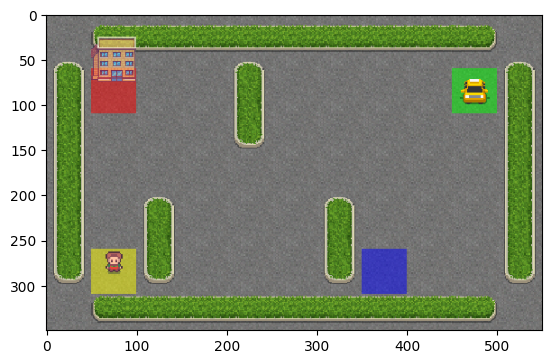

In [7]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
state, info = env.reset()
rep = env.render()
plt.imshow(rep)

Later, when we start training agents, we typically do not want to render the environment while training the agent since this slows down the training process. In such a case, you can just `make` the environment without specifying a `render_mode`. 

## 4.2 Driving the Taxi <a id="sec4_2">

So lets try to play around with the Taxi.

In [19]:
env = gym.make("Taxi-v3", render_mode="human")
state, info = env.reset()
print("Initial state:", state)

Initial state: 486


The objective in this environment is for the taxi to first drive to the passenger and pick her up, then drive her to the destination and drop her off. An RL agent should thus find a policy $a = \pi(s)$ that, for a given state $s$, returns an action $a$ in such a way that the objective is achieved.  

The set of all possible states is called the __state space__ $\mathcal{S}$, and the set of all possible actions is called the __action space__ $\mathcal{A}$. Let us see how these look for the Taxi-environment.

In [20]:
print("State space:", env.observation_space)
print("Action space:", env.action_space)

State space: Discrete(500)
Action space: Discrete(6)


__State space__: The state space contains 500 discrete states, so each state is a number between 0 and 499. Here, each state corresponds to the position of the taxi (25 possibilities), the passengers' position (5 possibilities, including picked up), and the destination (4 possibilities). Hence, there are $25\times5 \times 4 = 500$ possible states.

***Remark***: Note that we actually asked for the `observation_space` and not the state space. As mentioned above, we will assume that the observation and state spaces are the same for most of the course. However, in some RL problems, the full state cannot be observed, so the space of possible states may not be the same as that of possible observations. For example, the complete state of an inverted pendulum consists of both the angle and angular velocity, but maybe only the angle is measured directly.

__Action space__: The action space contains 6 discrete actions, so each action should be a number between 0 and 5. In the Taxi-environment, each action can be interpreted as follows:

In [21]:
DOWN = 0
UP = 1
RIGHT = 2
LEFT = 3
PICKUP = 4
DROPOFF = 5

Note, however, that when the RL agent starts to learn, it will not know the meaning of each state and action; instead, it has to try out different actions to see how they change the state. 

Let us now try to move the Taxi:

In [22]:
state, reward, terminated, truncated, info = env.step(UP) 
print("New state:",state)
print("Reward:", reward)
print("Terminated:", terminated)
print("Truncated:", truncated)
print("Info:", info)

New state: 386
Reward: -1
Terminated: False
Truncated: False
Info: {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}


If possible, the taxi should now have moved one step up (if it started at the top row, it will not move). 

The `step`-function returns the following information:

* __state__: The new state of the environment.
* __reward__: The immediate reward. In the taxi environment, the reward for illegal "pickup" or "dropoff" is -10; successfully delivering the passenger gives +20, and any other action gives -1. To maximize the total reward, you must thus deliver the passenger with as few actions as possible. 
* __terminated__: There are two different ways a Gymnasium environment can finish. The first is that it terminates because we reach a terminal state. In the Taxi environment, there is only one terminal state, namely the state where the passenger has been dropped off at the correct destination. 
* __truncated__: In Gymnasium environments, there may also be a fixed time limit that is not actually part of the environment (part of the Markov Decision Process). If an environment finishes due to this time limit, truncated is set to True.
* __info__: Just as `reset()`, `step()` also returns some information mainly used for debugging.

So how can we solve the Taxi problem? We need to determine the optimal action in each of the 500 states. With discrete states, it is possible to create an array with 500 entries, and in each entry, we specify the optimal action. 

__In Lecture 3__, we will see how dynamic programming can find the optimal action if the possible transitions in the environment are known. 

__In Lecture 4 - Lecture 5__, we will see how the optimal actions can be found even if nothing about the environment is known. This will be done by letting the agent explore how the environment reacts to different actions. 

For now, let us close the taxi environment and look at a MountainCar instead.

In [23]:
env.close()

# 5. The MountainCar <a id="sec5">

In [24]:
env = gym.make("MountainCar-v0", render_mode="human")
state, info = env.reset()
print("Initial state:", state)

Initial state: [-0.54355127  0.        ]


In this environment the goal is to get the car to the flag in as few steps as possible. 

In [25]:
print("State space:", env.observation_space)
print("Action space:", env.action_space)

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)


*  __Action space__: We have three discrete actions: 0—push left, 1—no push, and 2—push right.
* __State space__: `Box` represents a continuous space, in this case with two dimensions. The first element of the state is the car's horizontal position, which can range between -1.2 and +0.6. The second element is the car's horizontal velocity, ranging between -0.07 and +0.07.
* __Reward__: The reward given by the environment is -1 for each action. 
* __Terminal state__: The environment terminates if a state with a position greater than or equal to 0.5 is reached (0.5 is the position of the flag). Thus, to maximize the total reward, the agent should reach the flag in as few steps as possible. 
* __Truncation__: The environment will stop anyway if a terminal state is not reached within 200 time steps. Note that this is not actually part of the environment, it is just to ensure that the environment will stop even if the terminal state is never reached. 

Let's first try to solve this environment with the simple policy: Always push the car right (action = 2).

In [28]:
def policy(state):
    if state[1] > 0:
        action = 2
    elif state [1] < 0:
        action = 0
    else:
        action = 1
        
    return action  

In [37]:
def policy_leader(state):
    if state[1] >= min(-0.09 * (state[0]+0.25)**2 + 0.03, 0.3 * (state[0]+0.9)**4 - 0.008) and state[1] <= -0.07*(state[0]+0.38)**2 + 0.07:
        action = 2
    else:
        action = 0
    return action

In [40]:
env = gym.make('MountainCar-v0', render_mode="human")
state, info = env.reset()
time_step = 0
total_reward = 0
terminated = False
truncated = False
while not terminated and not truncated:
    action = policy_leader(state)
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    env.render()
    
    clear_output(wait=True)
    print("State:", state)
    print("Action:", action)
    print("Total reward:", total_reward)
    
env.close()

State: [0.5104187  0.02175295]
Action: 0
Total reward: -104.0


Unfortunately, the car does not have the momentum to overcome gravity, and thus, it never reaches the flag. The agent must learn that the car needs to gain momentum by going up the left hill.

This environment is harder than the Taxi-environment for RL agents. There are two reasons for this:
1. The state space is continuous (infinitely many states). Hence, building up a table with information about all states is impossible. In RL, this can be solved using function approximations. This will be discussed in the second half of the course.

2. The agent always gets the immediate reward -1 for each action until it reaches the flag. So, all actions look equally bad if we do not reach the flag before the environment truncates at 200 steps, and it is very unlikely that the car reaches the flag by only using, e.g., random actions. So how can it learn about the goal? We will see two possible solutions in the course: We can try re-engineering the reward so that the agent is encouraged to go up the left slope first. But this requires that we already know that this is a good idea. More generally, we can encourage the agent to try to reach states that have not been seen before.

Even though the problem is hard for an RL agent who knows nothing about the environment, it is relatively easy for an engineer who knows the basics of the environment to find a policy that (most of the time) reaches the flag within 200 steps. The strength of RL is that the agent can learn this only by interacting with the environment. However, when we know more about the environment, it can still be much more efficient to let an engineer figure out a good policy and potentially use RL to improve it.


***
### Task:
a) Try to construct a policy that only uses the current velocity (`state[1]`) to determine the action. The goal is to reach the flag within 200 steps most of the time. Implement your policy in the function `policy` above and try it. Remember to execute the cell with the function after you have made your changes. *Hint:* It is actually enough to check in which direction the car is currently moving (if velocity is positive or negative) to reach the flag within 200 time steps most of the time. 

b) Implement the policy that is on the [leaderboard](https://github.com/openai/gym/wiki/Leaderboard) for MountainCar-v0: ($p$ is position,  $v$ is velocity, and the state is $s = \begin{bmatrix} p & v \end{bmatrix}^\top$)
$$
\pi(s) = \begin{cases} \text{Right} & \text{if } \min\{-0.09( p + 0.25)^2 + 0.03, 0.3(p + 0.9)^4 - 0.008\} \leq v \leq -0.07(p+0.38)^2 + 0.07 \\ \text{Left} & \text{otherwise} \end{cases}
$$

***

# 6. Multi-armed bandits <a id="sec6">

This part of the notebook is based on Chapter 2 in the textbook. It will let you play around with some important RL concepts by trying out a relatively simple RL algorithm. To get a more complete discussion, it is recommended to read Chapters 2.1-2.6 in the textbook.

## 6.1 The environment <a id="sec6_1">

We consider 10 slot machines (one-armed bandits). You will repeatedly choose one of the slot machines, and each time you receive a random reward from a stationary distribution that depends on which slot machine you choose.

In [ ]:
env = gym.make("MultiarmedBandits-v0")
state, info = env.reset()

In [ ]:
print("State space:", env.observation_space)
print("Action space:", env.action_space)

__State space__: This environment has just one state since the slot machines do not change due to your actions. This simplifies the RL problem substantially. Since we do not have to consider how an action affects the state, we can concentrate on what immediate reward each action gives. 

__Action space__: $\mathcal{A} = \{ 0, 1, \ldots, 9\}$, so action $a=0$ means that we try slot machine $0$, $a=1$ means we try slot machine $1$ etc.

__Reward__: You get a random $R$ reward depending on the action you choose. Every time you `reset` the environment, the expected reward for each action will change. 

Let us try one of the slot machines:

In [ ]:
action = 0
state, reward, terminated, truncated, info = env.step(action)
print("Reward:", reward)

We now define the value of an action, $q_*(a)$, to be the expected reward when action $a$ is chosen, i.e.

$$
q_*(a) = \mathbb{E}[ R | a].
$$

Since there are 10 different actions, we represent $q_*(a)$ as an array with 10 elements in Python. In the `MultiarmedBandits` environment, the true values are stored in `env.unwrapped.values`. Here, we need to use `unwrapped` to access a variable that is typically not exposed to the agent (the agent will not have information about the true values). 

In [ ]:
print("True values:\n", env.unwrapped.values)

The action that maximizes the expected reward is thus the action with the largest value. If we know the true values $q_*(a)$, we can find that action with
$$
A = \underset{a \in \mathcal{A}}{\operatorname{argmax}} q_*(a),
$$
or in code

In [ ]:
optimal_action = np.argmax(env.unwrapped.values)
print("Optimal action:", optimal_action)

Let us now test using the best action and the worst action 1000 times each to see the difference.

In [ ]:
optimal_action = np.argmax(env.unwrapped.values)
worst_action = np.argmin(env.unwrapped.values)

rewards_optimal = np.zeros(1000)
rewards_worst = np.zeros(1000)

for i in range(1000):
    state, reward, terminated, truncated, info = env.step(optimal_action)
    rewards_optimal[i] = reward
    
    state, reward, terminated, truncated, info = env.step(worst_action)
    rewards_worst[i] = reward

In [ ]:
# Plot the rewards
plt.plot(rewards_optimal, label="Optimal action")
plt.plot(rewards_worst, label="Worst action")
plt.legend()
plt.ylabel("Reward")

# Print average reward and true value 
print("Optimal action. Average reward: %.2f, True value: %.2f"
      % (np.mean(rewards_optimal), env.unwrapped.values[optimal_action]))

print("Worst action. Average reward: %.2f, True value: %.2f"
      % (np.mean(rewards_worst), env.unwrapped.values[worst_action]))

So, if we know each action's true value, we can directly find the optimal action. However, the question is how an agent can **learn** what the optimal action is without knowing the true values. 

Note from the results above that if we have tested the two actions 1000 times, the average reward we received is relatively close to the true value. By looking at the average rewards, we can clearly determine which action is better. This idea will be used below to learn the optimal action. 

## 6.2 Learn <a id="sec6_2">

To estimate the true values $q_*(a)$ from observations, assume that we have taken $n-1$ actions and observed the reward for each action. To get an estimate $Q_n(a)$ of the true values, we compute the average reward received from action $a$ so far. 

That is, when $n-1$ actions have been taken, we can compute an estimate of $q_*(a)$ as

$$
Q_n(a) = \frac{ \text{ sum of rewards when $a$ taken prior to $n$} }{\text{number of times $a$  taken prior to $n$}} \quad \text{(see eq 2.1 in textbook)},
$$

where we let $Q_n(a) = 0$ if the action $a$ was not taken prior to the $n$th action. In particular, $Q_1(a) = 0$ for all $a$.

Instead of recomputing the sums every time a new action is taken, we can update this sum incrementally. Equation (2.3) in the textbook shows how to do this. That is, if the $n$th action taken is $A_n$, and the received reward is $R_n$, then $Q_{n+1}(A_n)$ can be computed from $Q_n(A_n)$ as
$$
Q_{n+1}(A_n) = Q_{n}(A_n) + \frac{1}{N(A_n)}(R_n - Q_n(A_n))
$$
where $N(A_n)$ is the number of times that $A_n$ has been taken so far. For all $a \neq A_{n}$, we have $Q_{n+1}(a) = Q_{n}(a)$ since we did not receive any new information about this action.

If we initialize the estimate to $Q_1(a) = 0$ for all $a \in \mathcal{A}$, then both expressions for $Q_n(a)$ are equivalent. For implementation, the second expression is quite useful. Here, we only need to create an array with 10 elements (one for each possible action), and whenever action $a$ is taken and the reward is observed, we update element $a$ in the array. 
Pseudo-code for this can be written as

*Initialize:*

For all $a \in \mathcal{A}$, 
  * $\quad Q(a) \leftarrow 0$
  * $\quad N(a) \leftarrow 0$
  
*Learn:*

When action $A$ is taken with received reward $R$, update the estimates:
  * $N(A) \leftarrow N(A) + 1$
  * $Q(A) \leftarrow Q(A) + \frac{1}{N(A)} (R - Q(A))$

## 6.3 Act and explore <a id="sec6_3">

Given an estimate $Q(a)$, how should the agent choose the next action? 

A straightforward answer is to choose the one that maximizes $Q(a)$. In RL, this is called the *greedy* choice, picking the action that seems best according to the current estimates.

However, assume that we initialize $Q(a)$ to zero for all actions. If the first action we take is $a=0$ and we receive a positive reward, we get $Q(0) > 0$, while $Q(a) = 0$ for all $a \neq 0$. The greedy choice is now $a=0$, so we choose this action again. As long as $Q(0)>0$, we will continue to choose $a=0$ and 
never learn about the other actions.

The problem is that if we always act greedily with respect to the current estimate, we may never explore other possible actions. A simple, but often quite effective, way of adding exploration is to let the agent use the greedy option most of the time, but with probability $\varepsilon$ take a random action.
This is called an $\varepsilon$-greedy policy. In this way, the agent will always continue to explore different possibilities. The $\varepsilon$-greedy policy given an estimate $Q(a)$ can be written as

$$
 \begin{cases} \underset{a \in \mathcal{A}}{\operatorname{argmax}} Q(a) & \text{with probability } 1-\varepsilon \\ \text{random action} & \text{with probability } \varepsilon\end{cases}
$$

When several actions have an estimate equal to the maximum, the agent can break ties any way it wants (e.g. randomly). 

## 6.4 Training the agent <a id="sec6_4">

Below we define a class `Agent` that does not learn anything and always choose a random action. In the tasks below you will update this code to implement learning and an $\varepsilon$-greedy policy. 

In [ ]:
class Agent():
    
    def __init__(self, epsilon=0, nr_arms=10):
        self.epsilon = epsilon
        self.nr_arms = nr_arms
        self.N = np.zeros(nr_arms)
        self.Q = np.zeros(nr_arms)
        
    def learn(self, action, reward):
        pass
        
    
    def act(self):
        action = np.random.choice(self.nr_arms) # Random action
            
        
            
        return action

We now let this agent take 10 000 actions, and compute the total reward. 

In [ ]:
env = gym.make("MultiarmedBandits-v0")
state, info = env.reset()
agent = Agent(epsilon = 1)
nr_actions = 10000
rewards = np.zeros(nr_actions)
for t in range(nr_actions):
    action = agent.act()
    state, reward, terminated, truncated, info = env.step(action)
    rewards[t] = reward
    agent.learn(action, reward)

print('Total reward:',  np.around(np.sum(rewards),2))
print('True values:\n', np.around(env.unwrapped.values,2))
print('Estimated values:\n', np.around(agent.Q,2))

Since the agent does not learn anything, all estimated values will be equal to zero. Your task is now to implement the learning and acting according to the discussion above. 

***
### Task

a) Change the `Agent`-class in order to implement an $\varepsilon$-greedy agent. To do this, change the `learn`-method to update $Q$ given an action with a corresponding reward. Then implement the $\varepsilon$-greedy policy in the `act`-function. (See discussion above for pseudo-code). ___Hint:___ `np.random.rand() > self.epsilon` has a probability of `1 - self.epsilon` to be `True`.

b) Try to re-run the code above a few times with your agent using $\varepsilon = 1$. In this case, if your code is correct, the estimated values and the true values should be similar (but not exactly equal).
 
c) Try to re-run the code above a few times with your agent using $\varepsilon = 0$. Try to explain the results. 

d) Try to re-run the code above with your agent using $\varepsilon = 0.01$ and $\varepsilon =0.5$. Do your estimated values improve as you increase $\varepsilon$? Why? What is the drawback of increasing $\varepsilon$?

e) When you have tested that your implementation works, you can run the code below the reproduce plots like in Figure 2.2 in the textbook. Here we consider 2000 episodes (with different bandit problems) where the agent takes 1000 actions each episode. The average reward at different time steps is then tested. Try to use different $\varepsilon$. (Running this code may take some minutes). Compare your results with those of Figure 2.2 in the textbook.
***

In [ ]:
epsilon = 0.1 # Change this to try different values
rewards = np.zeros((2000, 1000)) 
optimal = np.zeros((2000, 1000)) # Using optimal action?

for i in range(2000):
    agent = Agent(epsilon = epsilon)
    env.reset()     
    optimal_action = np.argmax(env.unwrapped.values)
    
    for t in range(1000):
        action = agent.act()
        
        if action == optimal_action:
            optimal[i,t] = 1
        else:
            optimal[i,t] = 0
            
        state, reward, terminated, truncated, info = env.step(action)
        rewards[i,t] = reward
        
        agent.learn(action, reward)

In [ ]:
# Plot the average reward in each time step
mean_rewards = np.mean(rewards, 0)
plt.plot(mean_rewards)
plt.xlabel("Steps")
plt.ylabel("Average reward");

In [ ]:
# Plot how often optimal action is chosen
mean_optimal = np.mean(optimal,0)
plt.plot(mean_optimal)
plt.xlabel("Steps")
plt.ylabel("% Optimal action");